In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import sample
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score, KFold
from pandas import *
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import sys
import numpy.random as rd
import pandas as pd

from sklearn.mixture import GaussianMixture
from collections import Counter
import matplotlib.colors as mcolors
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from collections import Counter
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.fftpack import fft,ifft, rfft, irfft
from scipy.fftpack import dct,idct

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# This is the place where your Capstone folder should be
main_path = os.getcwd()
print(main_path)

C:\Users\Max Tchibozo\Desktop\CAPSTONE\Capstone-Fall-2020


In [3]:
class TS_generator:
  def __init__(self, nb_timeseries=2000, chunk_size=100):
    
    self.chunk_size = chunk_size
    self.nb_timeseries = nb_timeseries

    #Retrieve the stocks names
    self.symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/sp500.csv', index_col=False)
    self.symbols = list(self.symbols['Symbol'].values)
    self.symbols = ['BF-B' if x=='BF.B' else x for x in self.symbols]
    self.symbols = ['BRK-B' if x=='BRK.B' else x for x in self.symbols]

    self.list_df = []

    #Build the random time series
    self.build_()

  def build_(self):    
    for _ in range(self.nb_timeseries):

      #Pick a random stock
      stock = self.symbols[rd.randint(len(self.symbols))]
      TS = pd.read_csv('data/'+stock+'.csv')
      
      #Pick a random starting point
      timemax = len(TS) - self.chunk_size
      start = rd.randint(timemax)
      stock_df = TS[start : start+self.chunk_size]

      self.list_df.append( stock_df )

  def get_list_of_df(self):
    #
    return self.list_df

  def get_array(self):
    #Return adjusted close array
    close_array = np.zeros((self.nb_timeseries, self.chunk_size))

    for i in range(self.nb_timeseries):
      close_array[i,:] = self.list_df[i]['Adj Close'].to_numpy()

    return close_array

In [4]:
nb_timeseries = 1000

gen = TS_generator(nb_timeseries=nb_timeseries, chunk_size=100) #default values but just for the syntax
X = gen.get_array()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


In [5]:
train_test_split = int(0.8*len(X))
X_train = X[:train_test_split]
X_test = X[train_test_split:]


## This part is some Maxime code

## Important to note: for some algorithms: cluster mean =/= cluster centroid (at least not always).

Don't fit the cluster mean, fit the cluster center (as defined by your model/estimators - kmeans.cluster_centers_ for example).

## KMeans Clustering

In [104]:
# GMM take a while to train
n_clusters = 20
km = KMeans(n_clusters)
km.fit(X_train)
y_train_pred = km.predict(X_train)


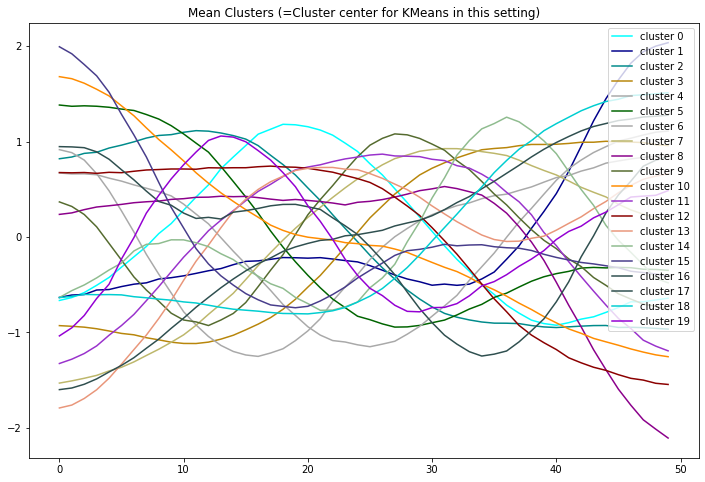

In [106]:
plt.figure(figsize=(12,8))
for k in range(n_clusters):
    cluster_indices = [i for i,x in enumerate(y_train_pred) if x == k]
    cluster_center = km.cluster_centers_[k]#np.mean(X_train[cluster_indices,:],axis=0)
    plt.plot(cluster_center,color = list(mcolors.CSS4_COLORS)[20+k],label='cluster '+str(k))
plt.legend(loc = "upper right")
plt.title('Mean Clusters (=Cluster center for KMeans in this setting)')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy 

<Figure size 1440x1440 with 0 Axes>

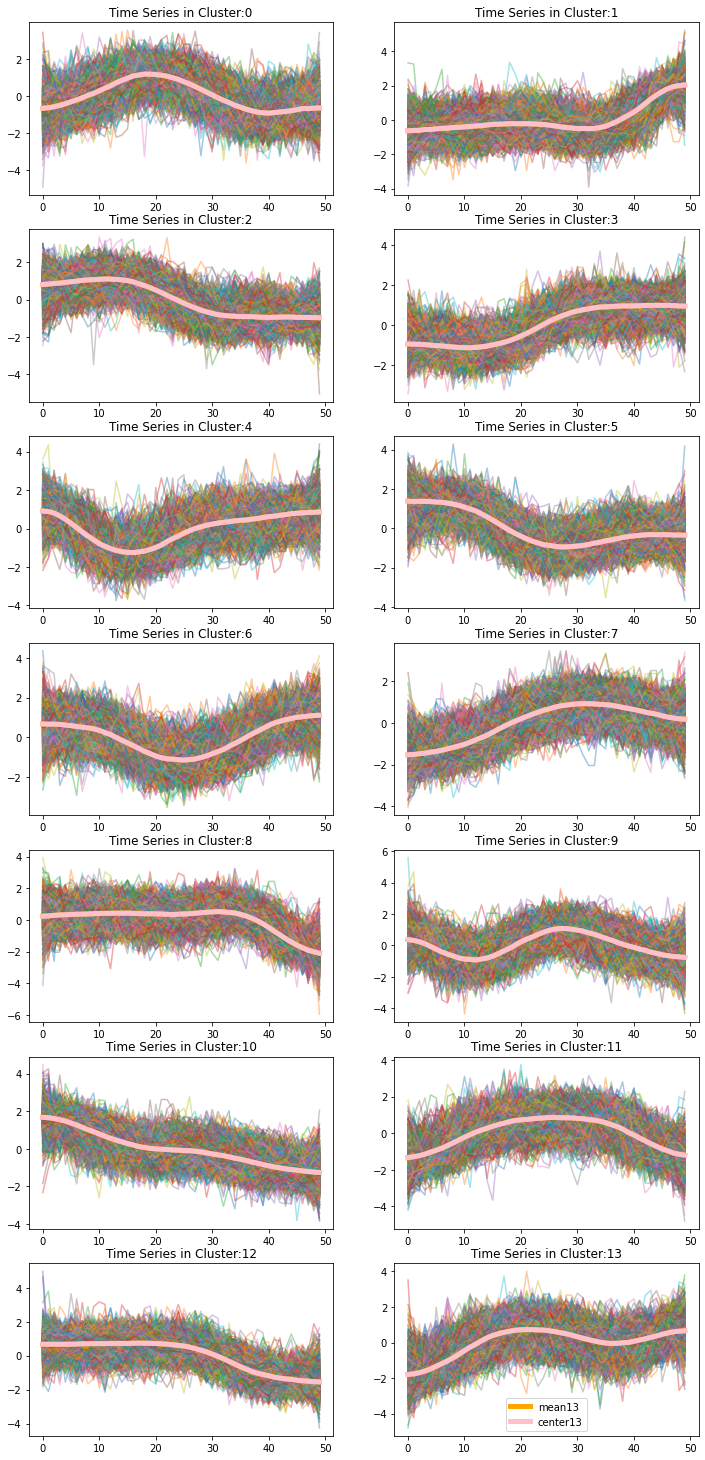

In [107]:
plt.figure(figsize=(20,20))
fig, axes = plt.subplots(7, 2,figsize=(12,26))
axes_list = list(axes.flatten())
for cluster_nb in range(14):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]
    cluster_mean = np.mean(X_train[indices,:],axis=0)
    cluster_center = km.cluster_centers_[cluster_nb]
    ax = axes_list[cluster_nb]
    ax.title.set_text('Time Series in Cluster:'+str(cluster_nb))
    for i in range(len(indices)):
        ax.plot(X_train[indices[i]],alpha=0.4)
    ax.plot(cluster_mean,color='orange',linewidth=5,alpha=1,label="mean"+str(cluster_nb))
    ax.plot(cluster_center,color='pink',linewidth=5,alpha=1,label="center"+str(cluster_nb))
plt.legend()
plt.show()

Ok fine... in the case of KMeans on a regular time series, cluster center = cluster mean.

## Gaussian Mixture Models

-- just an idea

In [67]:
# GMM take a while to train
n_clusters = 20
gm = GaussianMixture(n_clusters)
gm.fit(X_train)

GaussianMixture(n_components=20)

In [68]:
# This is to see how many points there are in each cluster
y_train_pred = gm.predict(X_train)
print(y_train_pred)
print(Counter(y_train_pred)) 

[ 0 13  1 ... 16 10  2]
Counter({13: 3808, 4: 3174, 16: 2923, 2: 2703, 7: 2636, 15: 2404, 1: 2366, 3: 2174, 8: 1938, 17: 1875, 18: 1725, 19: 1710, 11: 1616, 0: 1562, 9: 1371, 5: 1270, 14: 1181, 12: 1124, 10: 1031, 6: 509})


<Figure size 864x504 with 0 Axes>

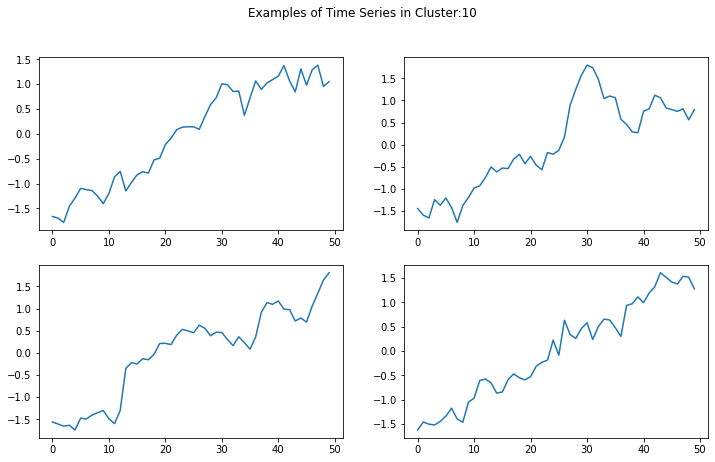

In [15]:
# We Look at the type of values that have been stored in cluster 10
cluster_nb = 10
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

<Figure size 864x504 with 0 Axes>

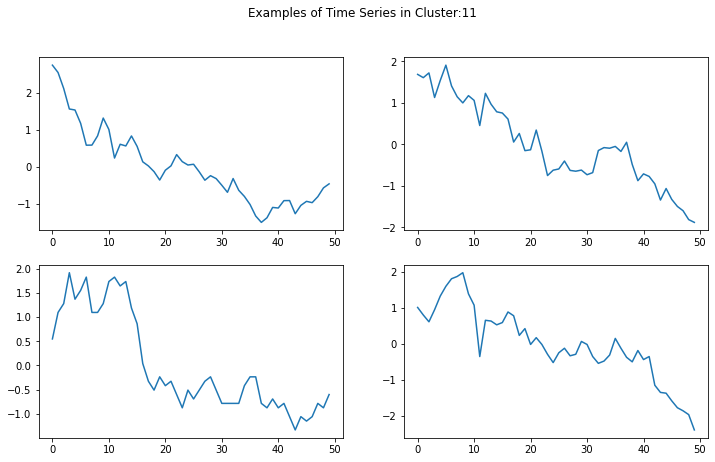

In [16]:
# We Look at the type of values that have been stored in cluster 10
cluster_nb = 11
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-pa

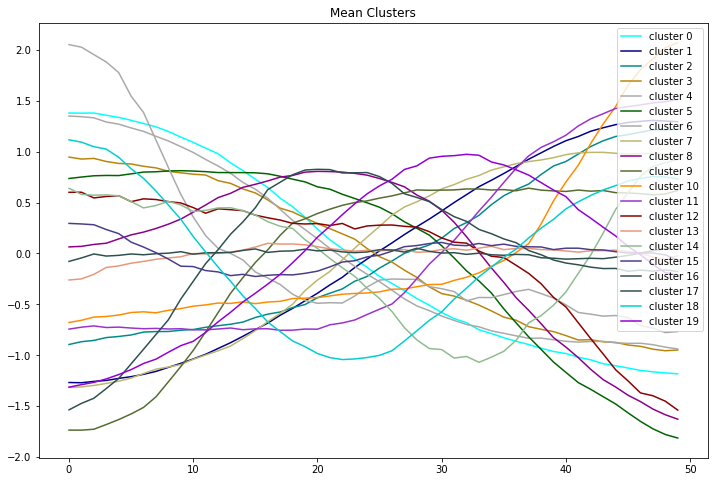

In [69]:
plt.figure(figsize=(12,8))
for k in range(n_clusters):
    cluster_indices = [i for i,x in enumerate(y_train_pred) if x == k]
    cluster_mean = np.mean(X_train[cluster_indices,:],axis=0)
    plt.plot(cluster_mean,color = list(mcolors.CSS4_COLORS)[20+k],label='cluster '+str(k))
plt.legend(loc = "upper right")
plt.title('Mean Clusters')
plt.show()

Like KMeans, GMM just seem to capture simple harmonics (sine waves). I think we can do better...

<Figure size 864x504 with 0 Axes>

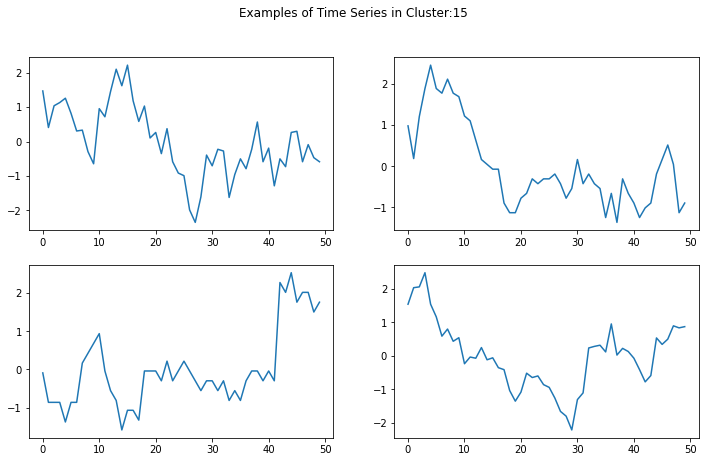

In [17]:
# We Look at the type of values that have been stored in cluster 15
cluster_nb = 15
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

## Dynamic Time Warping (DTW)

Quick link: https://medium.com/@shachiakyaagba_41915/dynamic-time-warping-with-time-series-1f5c05fb8950

Best way to understand is to get your hands dirty: https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html

DTW is a promising approach IMO.

In [4]:
n_clusters = 40

model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
model.fit(X_train[:4000])

TimeSeriesKMeans(metric='dtw', n_clusters=40)

In [5]:
warped_X_train = model.transform(X_train[:4000])

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [6]:
warped_X_train.shape # this is some kind of embedding - it does not have the initial shape (50,)

(4000, 40)

In [7]:
y_train_pred = model.predict(X_train[:4000])
#print(y_train_pred)
print(Counter(y_train_pred)) 

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Counter({25: 189, 20: 184, 39: 179, 16: 166, 24: 153, 10: 150, 33: 135, 3: 134, 18: 123, 38: 115, 1: 111, 15: 110, 17: 109, 8: 108, 22: 104, 37: 99, 11: 98, 32: 95, 4: 94, 29: 93, 35: 92, 23: 91, 12: 88, 13: 85, 27: 84, 26: 84, 21: 84, 30: 81, 2: 80, 14: 77, 31: 75, 6: 72, 9: 66, 36: 65, 28: 63, 7: 61, 5: 56, 19: 55, 34: 52, 0: 40})


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


<Figure size 864x504 with 0 Axes>

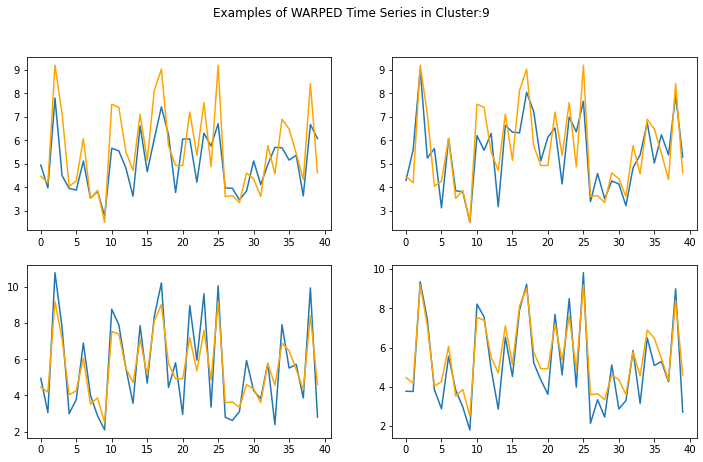

In [8]:
cluster_nb = 9
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

warped_cluster_mean = np.mean(warped_X_train[indices,:],axis=0)

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of WARPED Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(warped_X_train[indices[0]])
axes[0,0].plot(warped_cluster_mean,color='orange')

axes[0,1].plot(warped_X_train[indices[1]])
axes[0,1].plot(warped_cluster_mean,color='orange')

axes[1,0].plot(warped_X_train[indices[2]])
axes[1,0].plot(warped_cluster_mean,color='orange')

axes[1,1].plot(warped_X_train[indices[3]])
axes[1,1].plot(warped_cluster_mean,color='orange')
plt.show()

Be careful when interpreting the above curves: These are no longer the same time series as we knew them, these are DTW embeddings of the time series.

<Figure size 864x504 with 0 Axes>

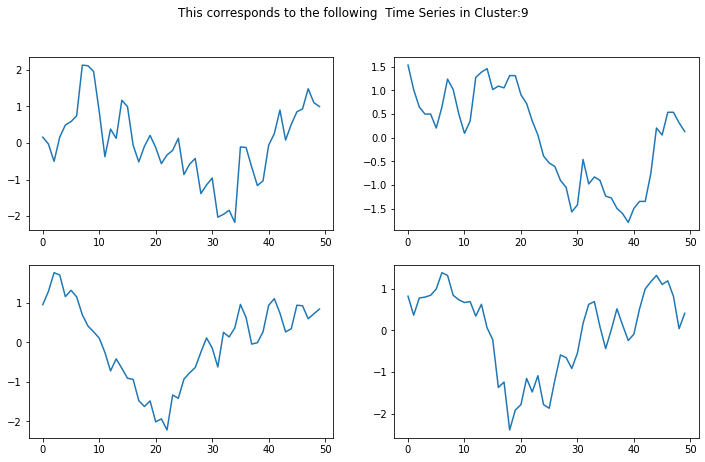

In [88]:
cluster_nb = 9
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('This corresponds to the following TRUE Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])

plt.show()

This is a good sign (Thanks Hritik!) the decreasing spike trend has been captured by this cluster, even though the spike does not happen at the same time for all time series.

Hritik's point was that once we use Dynamic Time Warping (DTW), it no longer makes sense to take of the mean of the time series within a cluster. Since the same pattern may appear in different places on different time series, they would be averaged out when computing the mean.

### Let's look at a few other clusters

<Figure size 864x504 with 0 Axes>

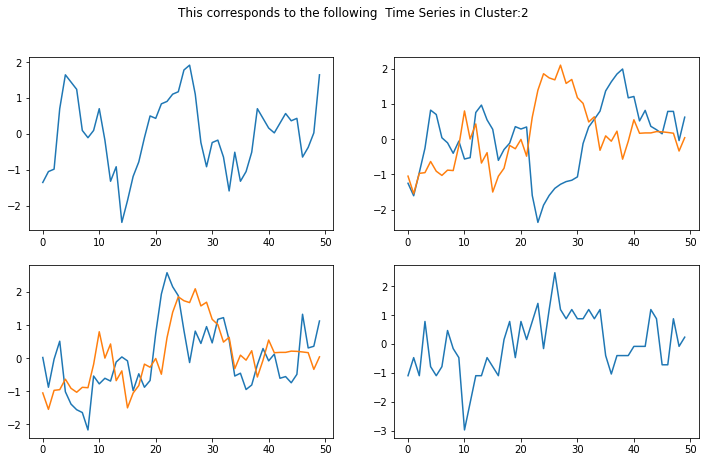

In [97]:
cluster_nb = 2
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('This corresponds to the following  Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])
#axes[0,0].plot(model.cluster_centers_[cluster_nb])

axes[0,1].plot(X_train[indices[1]])
axes[0,1].plot(model.cluster_centers_[cluster_nb])

axes[1,0].plot(X_train[indices[2]])
axes[1,0].plot(model.cluster_centers_[cluster_nb])

axes[1,1].plot(X_train[indices[3]])
#axes[1,1].plot(model.cluster_centers_[cluster_nb])

plt.show()

Here, the orange line corresponds to the cluster center. All of these time series have been assigned to the same cluster. Try shifting the orange line to the left or to the right to see if you agree these Time Series should be clustered together.

I only put the orange line for two plots, but you could do it for all of them.

<Figure size 864x504 with 0 Axes>

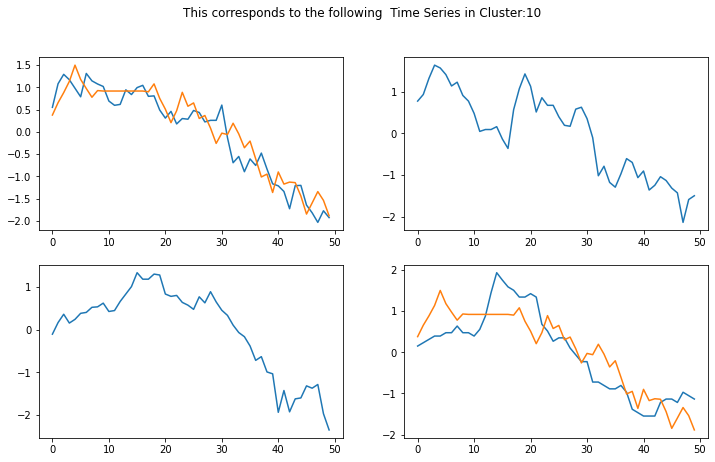

In [100]:
cluster_nb = 10
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('This corresponds to the following  Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])
axes[0,0].plot(model.cluster_centers_[cluster_nb])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
axes[1,1].plot(model.cluster_centers_[cluster_nb])

plt.show()

<Figure size 1440x1440 with 0 Axes>

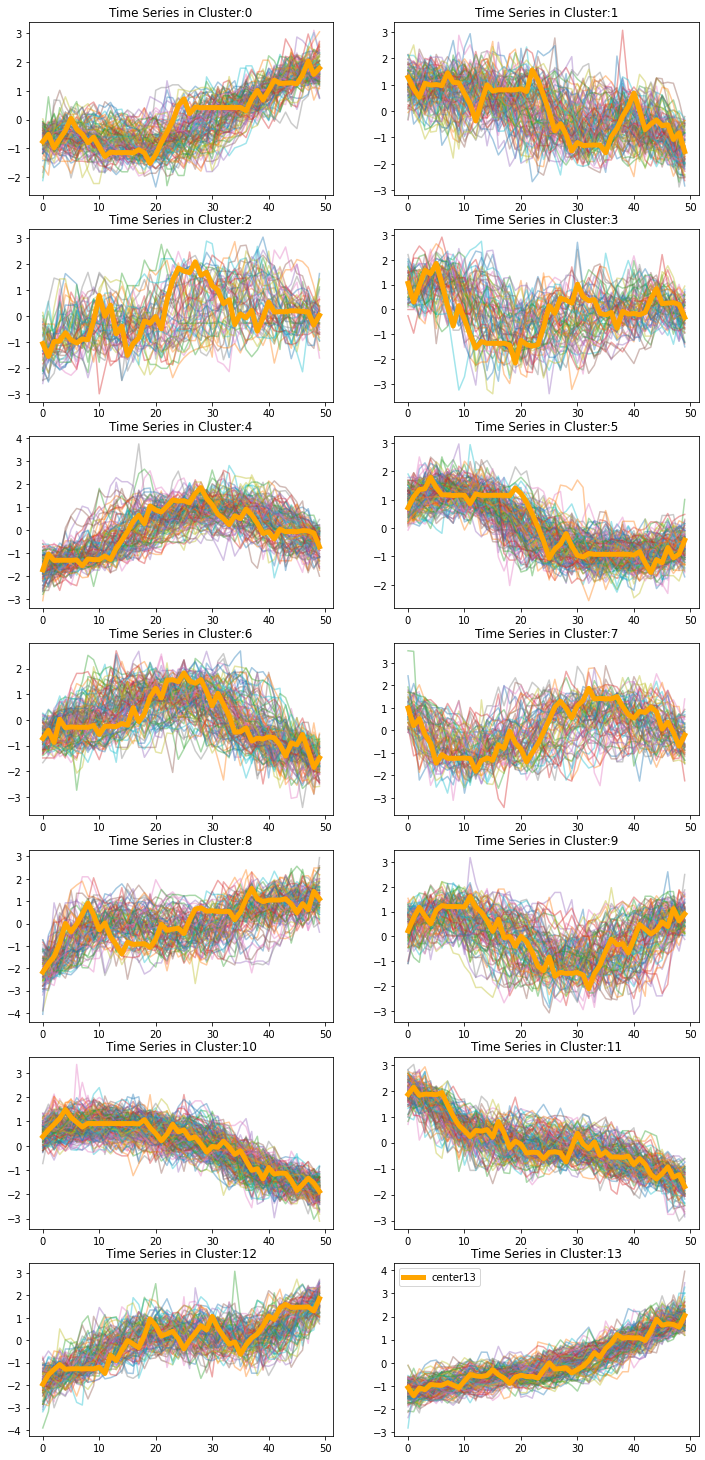

In [102]:
plt.figure(figsize=(20,20))
fig, axes = plt.subplots(7, 2,figsize=(12,26))
axes_list = list(axes.flatten())
for cluster_nb in range(14):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]
    cluster_center = model.cluster_centers_[cluster_nb]
    ax = axes_list[cluster_nb]
    ax.title.set_text('Time Series in Cluster:'+str(cluster_nb))
    for i in range(len(indices)):
        ax.plot(X_train[indices[i]],alpha=0.4)
    ax.plot(cluster_center,color='orange',linewidth=5,alpha=1,label="center"+str(cluster_nb))
plt.legend()
plt.show()

As you can see, here, cluster center is not equal to cluster mean. The cluster mean would have been a smooth average of all the points.
Here, cluster center is defined as per the DTW algorithm.

## What about a DTW embedding with GMM clustering?

In [ ]:
# TODO

# Something to think about! You can do DTW with a custom distance metric - for example if we are working with matrices, we could adapt a DTW algorithm to that type of input.

https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw_custom_metric.html#sphx-glr-auto-examples-metrics-plot-dtw-custom-metric-py


# Signal processing approach

https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442

- Fourier Transform

- Seq2Seq

https://www.youtube.com/watch?v=VYpAodcdFfA

- Multi Scale Time Series Clustering

## Fourier Transform

Assumptions of the FT:
- periodicity of the signal
- sampling frequency $F_s$ s.t $\frac{1}{T}=\frac{F_s}{N_s}$
- $f_{max} = 2*F_s$

- https://medium.com/@khairulomar/deconstructing-time-series-using-fourier-transform-e52dd535a44e
- determining $F_s$ https://knowledge.ni.com/KnowledgeArticleDetails?id=kA00Z0000019MIYSA2


In [6]:

X_scaled = StandardScaler().fit_transform(X_train.T).T

In [7]:
X_ft = fft(X_scaled)
print(X_ft[0][:10]) #first 10 coefficients

[ 6.88338275e-15 -0.j          5.62937001e+01-10.12787961j
 -1.05211453e+01-13.71911376j  1.28911326e+01-16.56217641j
 -8.68322993e+00 -6.38642219j  1.17031850e+01 +8.52705274j
  6.50594917e-01-12.56217538j -7.46534509e-02+10.10641807j
  5.18644463e+00 -2.29848943j -3.20933889e+00 -3.22527826j]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\ProgramDat

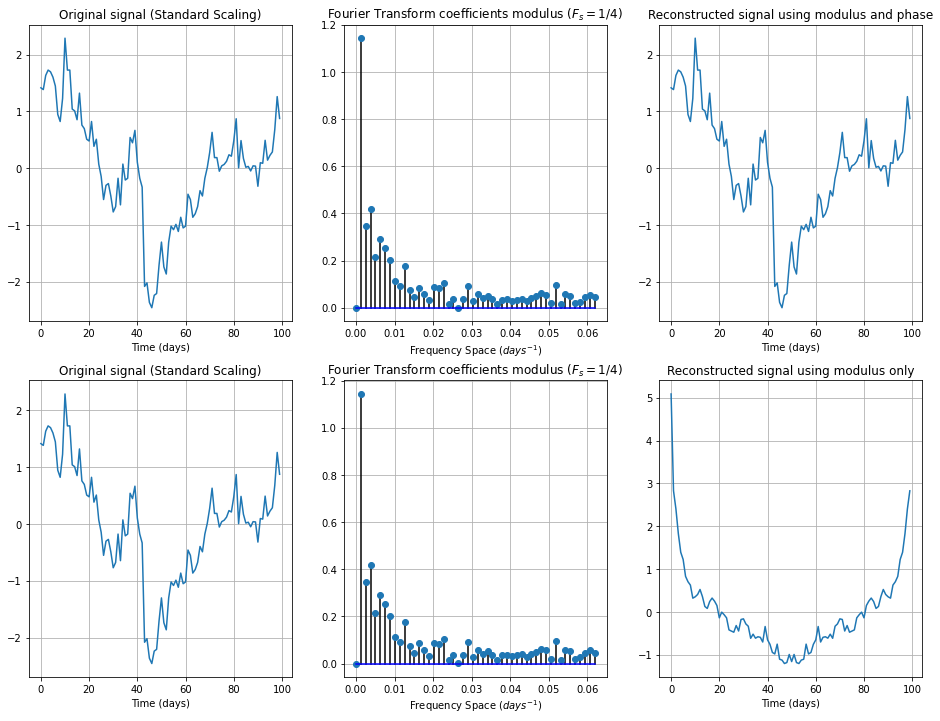

In [9]:
#First approach: Use modulus only
i=0
j=2

Fs = 1/4 #1/4 # sampling rate: f_max /2 - let's say the smallest pattern is 2 days
n = X_scaled.shape[1]
fr = Fs/2 * np.linspace(0,1,n)
X_ft_mod = 2/n * abs(X_ft)[:,0:np.size(fr)//2]

X_ft_mod_reconstructed = ifft(abs(X_ft)).real
X_ft_reconstructed = ifft(X_ft).real

fig, axes = plt.subplots(2,3,figsize=(16,12))

axes[0,0].plot(X_scaled[i])
axes[0,0].set_xlabel('Time (days)')
axes[0,0].set_title('Original signal (Standard Scaling)')
axes[0,0].grid()

axes[0,1].set_title('Fourier Transform coefficients modulus ($F_s = 1/4 $)')
axes[0,1].stem(fr[:np.size(fr)//2],X_ft_mod[i],linefmt='k',basefmt='b')
axes[0,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[0,1].grid()

axes[0,2].plot(X_ft_reconstructed[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[0,2].set_title('Reconstructed signal using modulus and phase')
axes[0,2].set_xlabel('Time (days)')
axes[0,2].grid()

axes[1,0].plot(X_scaled[i])
axes[1,0].set_xlabel('Time (days)')
axes[1,0].set_title('Original signal (Standard Scaling)')
axes[1,0].grid()

axes[1,1].set_title('Fourier Transform coefficients modulus ($F_s = 1/4 $)')
axes[1,1].stem(fr[:np.size(fr)//2],X_ft_mod[i],linefmt='k',basefmt='b')
axes[1,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[1,1].grid()

axes[1,2].plot(X_ft_mod_reconstructed[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[1,2].set_title('Reconstructed signal using modulus only')
axes[1,2].set_xlabel('Time (days)')
axes[1,2].grid()

plt.savefig('FT_intro.png')
plt.show()

Fourier series are not great for reconstruction using modulus only, but perhaps they are useful for clustering! We have basically gotten rid of all the phases (=translations in space).

In [10]:
n_clusters = 10
km = KMeans(n_clusters)

X_ft_real_imag = np.concatenate((X_ft.real,X_ft.imag),axis=1)


km.fit(X_ft_real_imag)
y_train_pred = km.predict(X_ft_real_imag)

print(Counter(y_train_pred))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


Counter({7: 160, 0: 130, 5: 82, 1: 75, 4: 69, 2: 64, 3: 59, 9: 58, 8: 58, 6: 45})


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


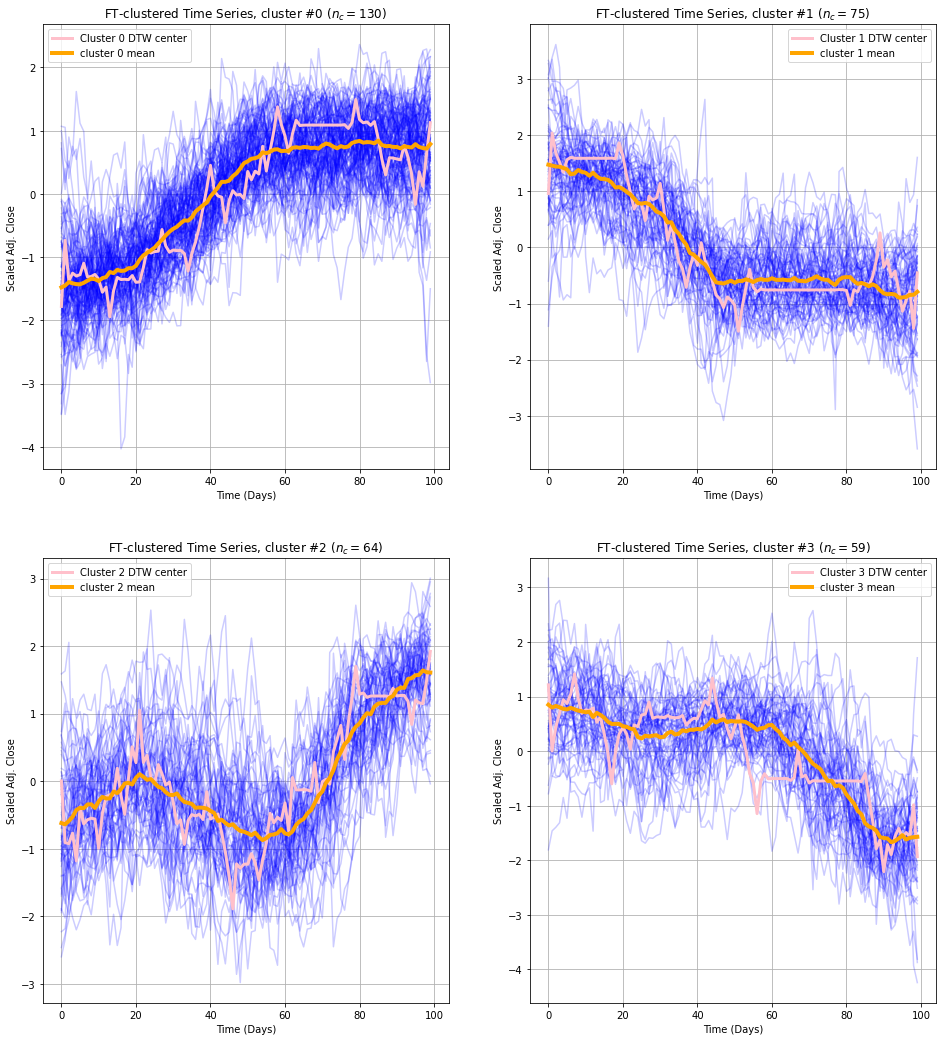

In [12]:
fig, axes = plt.subplots(2, 2,figsize=(16,18))
axes_list = list(axes.flatten())

for cluster_nb in range(4):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]
    dtw_cluster =  TimeSeriesKMeans(n_clusters=1, metric="dtw")
    dtw_cluster.fit(X_scaled[indices])
    dtw_cluster_center = dtw_cluster.cluster_centers_[0]
    cluster_mean = np.mean(X_scaled[indices],axis=0)
    ax = axes_list[cluster_nb]
    ax.title.set_text('FT-clustered Time Series, cluster #'+str(cluster_nb)+' ($n_c='+str(len(indices))+'$)')
    for i in range(len(indices)):
        ax.plot(X_scaled[indices[i]],alpha=0.2,color='b')
    ax.plot(dtw_cluster_center,color='pink',linewidth=3,alpha=1,label="Cluster "+str(cluster_nb)+" DTW center")
    ax.plot(cluster_mean,color='orange',linewidth=4,alpha=1,label="cluster "+str(cluster_nb)+" mean")
    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('Scaled Adj. Close')
    ax.grid()
    ax.legend()
plt.savefig('FT_clusters.png')
plt.show()

### Discrete Cosine Transform

An exploration of the properties of DCT

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


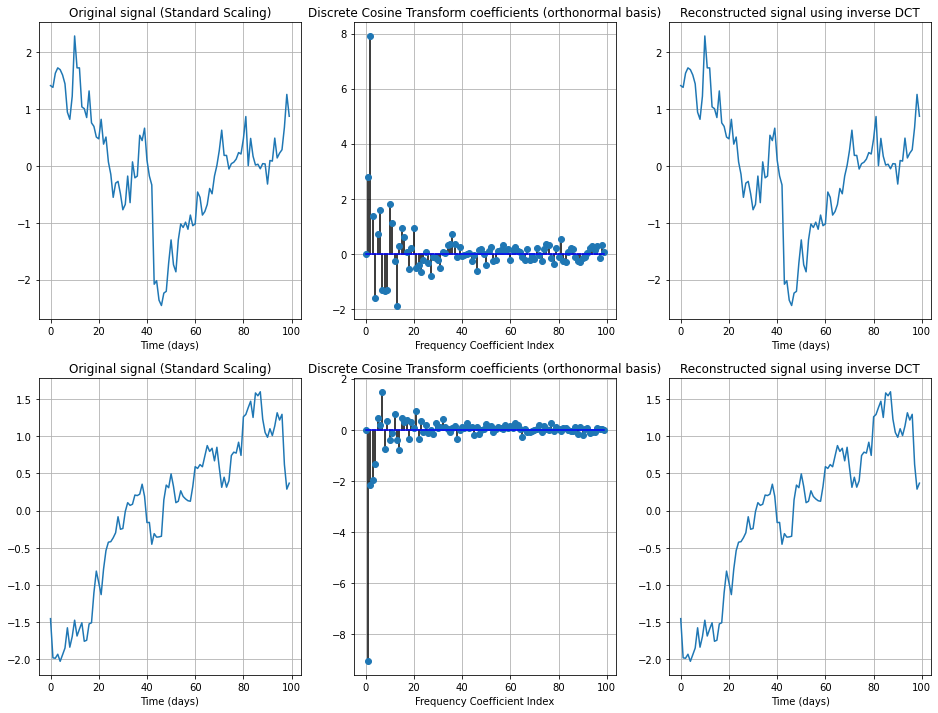

In [16]:
#DCT
i=0
j=2

X_dct = dct(X_scaled,norm='ortho',n=100)
X_dct_reconstructed = idct(X_dct,norm='ortho',n=100)

fig, axes = plt.subplots(2,3,figsize=(16,12))

axes[0,0].plot(X_scaled[i])
axes[0,0].set_xlabel('Time (days)')
axes[0,0].set_title('Original signal (Standard Scaling)')
axes[0,0].grid()

axes[0,1].set_title('Discrete Cosine Transform coefficients (orthonormal basis)')
axes[0,1].stem(X_dct[i],linefmt='k',basefmt='b')
axes[0,1].set_xlabel('Frequency Coefficient Index')
axes[0,1].grid()

axes[0,2].plot(X_dct_reconstructed[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[0,2].set_title('Reconstructed signal using inverse DCT')
axes[0,2].set_xlabel('Time (days)')
axes[0,2].grid()

axes[1,0].plot(X_scaled[j])
axes[1,0].set_xlabel('Time (days)')
axes[1,0].set_title('Original signal (Standard Scaling)')
axes[1,0].grid()

axes[1,1].set_title('Discrete Cosine Transform coefficients (orthonormal basis)')
axes[1,1].stem(X_dct[j],linefmt='k',basefmt='b')
axes[1,1].set_xlabel('Frequency Coefficient Index')
axes[1,1].grid()

axes[1,2].plot(X_dct_reconstructed[j])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[1,2].set_title('Reconstructed signal using inverse DCT')
axes[1,2].set_xlabel('Time (days)')
axes[1,2].grid()
plt.savefig('DCT_intro.png')
plt.show()

In [14]:
n_clusters = 10
km = KMeans(n_clusters)
km.fit(X_dct)
y_train_pred = km.predict(X_dct)

print(Counter(y_train_pred))

Counter({2: 162, 7: 125, 6: 87, 9: 70, 1: 69, 8: 67, 5: 63, 3: 57, 4: 54, 0: 46})


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


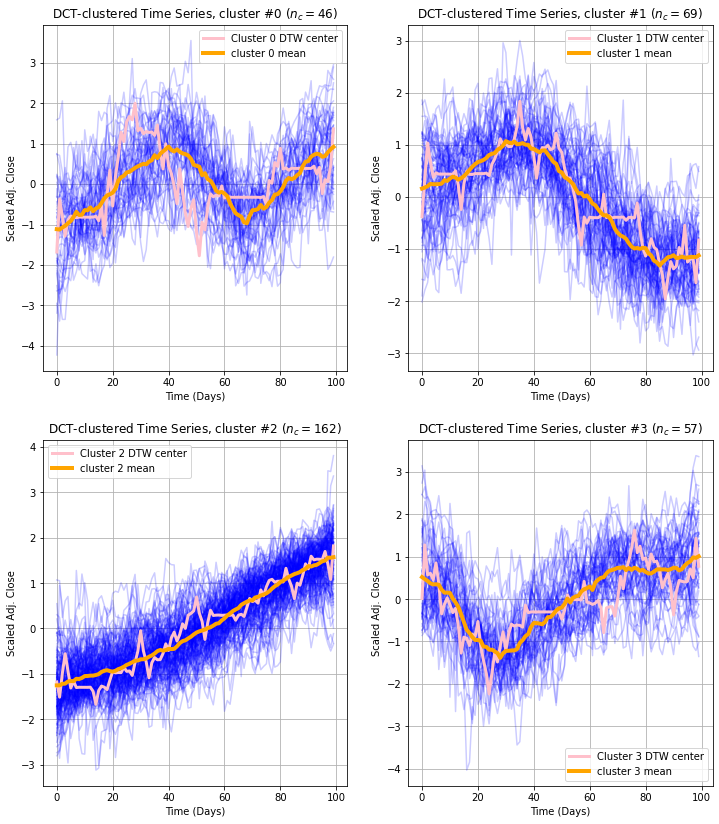

In [15]:
fig, axes = plt.subplots(2, 2,figsize=(12,14))
axes_list = list(axes.flatten())

for cluster_nb in range(4):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]
    dtw_cluster =  TimeSeriesKMeans(n_clusters=1, metric="dtw")
    dtw_cluster.fit(X_scaled[indices])
    dtw_cluster_center = dtw_cluster.cluster_centers_[0]
    cluster_mean = np.mean(X_scaled[indices],axis=0)
    ax = axes_list[cluster_nb]
    ax.title.set_text('DCT-clustered Time Series, cluster #'+str(cluster_nb)+' ($n_c='+str(len(indices))+'$)')
    for i in range(len(indices)):
        ax.plot(X_scaled[indices[i]],alpha=0.2,color='b')
    ax.plot(dtw_cluster_center,color='pink',linewidth=3,alpha=1,label="Cluster "+str(cluster_nb)+" DTW center")
    ax.plot(cluster_mean,color='orange',linewidth=4,alpha=1,label="cluster "+str(cluster_nb)+" mean")
    ax.set_xlabel('Time (Days)')
    ax.set_ylabel('Scaled Adj. Close')
    ax.grid()
    ax.legend()
plt.savefig('DCT_clusters.png')
plt.show()

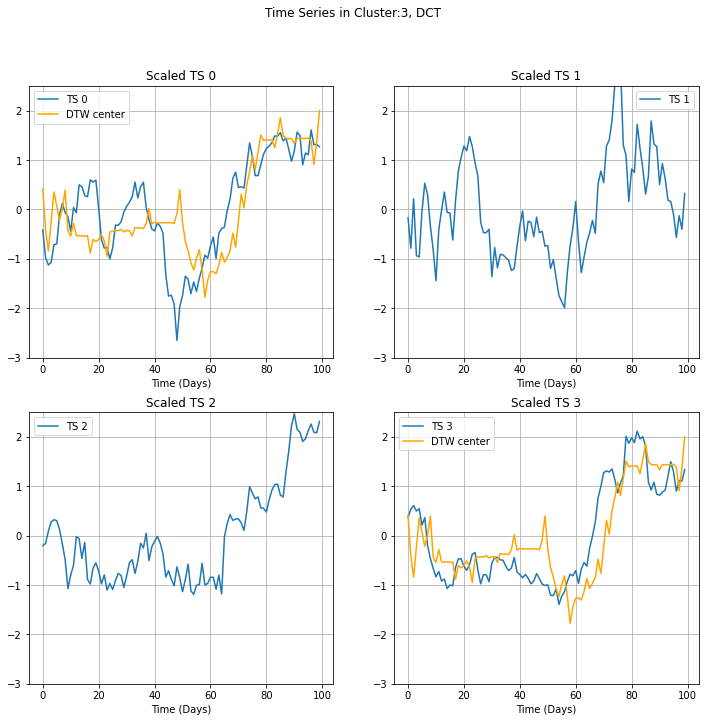

In [137]:
cluster_nb = 3
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

dtw_cluster = TimeSeriesKMeans(n_clusters=1, metric="dtw")
dtw_cluster.fit(X_scaled[indices])

DTW_aligned_cluster_mean = dtw_cluster.cluster_centers_[0]

fig, axes = plt.subplots(2, 2,figsize=(12,11))
fig.suptitle('Time Series in Cluster:'+str(cluster_nb)+', DCT')
axes[0,0].plot(X_scaled[indices[0]],label='TS 0')
axes[0,0].plot(DTW_aligned_cluster_mean,color='orange',label="DTW center")
axes[0,0].set_title('Scaled TS 0')
axes[0,0].set_xlabel('Time (Days)')
axes[0,0].set_ylim([-3,2.5])
axes[0,0].legend()
axes[0,0].grid()

axes[0,1].plot(X_scaled[indices[1]],label='TS 1')
axes[0,1].set_title('Scaled TS 1')
axes[0,1].set_xlabel('Time (Days)')
axes[0,1].set_ylim([-3,2.5])
axes[0,1].legend()
axes[0,1].grid()

axes[1,0].plot(X_scaled[indices[2]],label='TS 2')
axes[1,0].set_title('Scaled TS 2')
axes[1,0].set_xlabel('Time (Days)')
axes[1,0].set_ylim([-3,2.5])
axes[1,0].legend()
axes[1,0].grid()

axes[1,1].plot(X_scaled[indices[3]],label='TS 3')
axes[1,1].plot(DTW_aligned_cluster_mean,color='orange',label="DTW center")
axes[1,1].set_title('Scaled TS 3')
axes[1,1].set_xlabel('Time (Days)')
axes[1,1].set_ylim([-3,2.5])
axes[1,1].legend()
axes[1,1].grid()
plt.savefig('DCT_cluster.png')
plt.show()

### This part next part (until wavelets) doesn't really matter, just to evaluate DCT from a compression point of view. Please ignore.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


[]

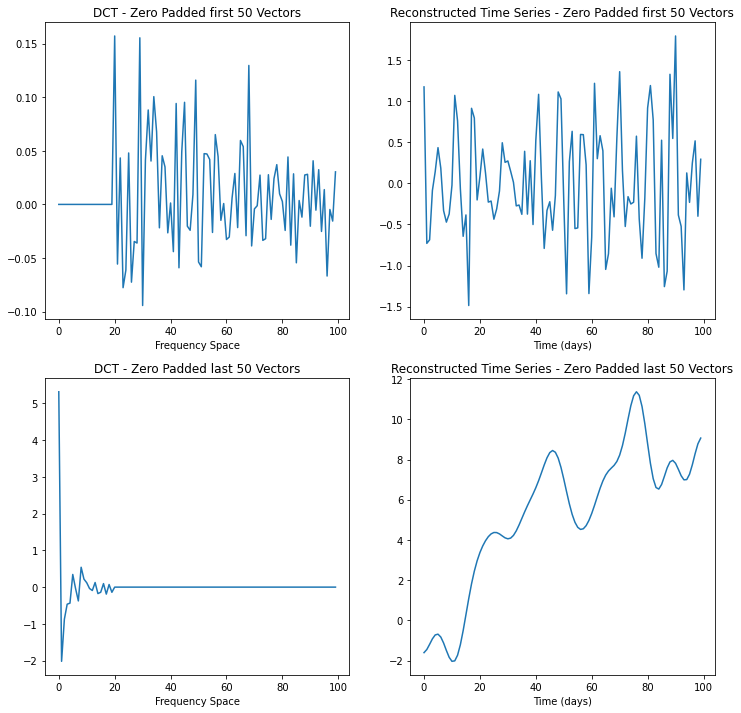

In [108]:
#Question: What signal is contained in the 50 first and last dimensions of the transform
y_cos_start_zero = y_cos.copy()
y_cos_start_zero[:20] = np.zeros(20)
y_cos_end_zero = y_cos.copy()
y_cos_end_zero[20:] = np.zeros(80)

fig, axes = plt.subplots(2,2,figsize=(12,12))

axes[0,0].plot(y_cos_start_zero)
axes[0,0].set_title('DCT - Zero Padded first 50 Vectors')
axes[0,0].set_xlabel('Frequency Space')

axes[0,1].plot(idct(y_cos_start_zero))
axes[0,1].set_title('Reconstructed Time Series - Zero Padded first 50 Vectors')
axes[0,1].set_xlabel('Time (days)')

axes[1,0].plot(y_cos_end_zero)
axes[1,0].set_title('DCT - Zero Padded last 50 Vectors')
axes[1,0].set_xlabel('Frequency Space')

axes[1,1].plot(idct(y_cos_end_zero))
axes[1,1].set_title('Reconstructed Time Series - Zero Padded last 50 Vectors')
axes[1,1].set_xlabel('Time (days)')

plt.plot()

First observation: Be wary of Zero Padding with DCT, it changes the scale of the reconstructed signal. We can try simply shortening the embeddings instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


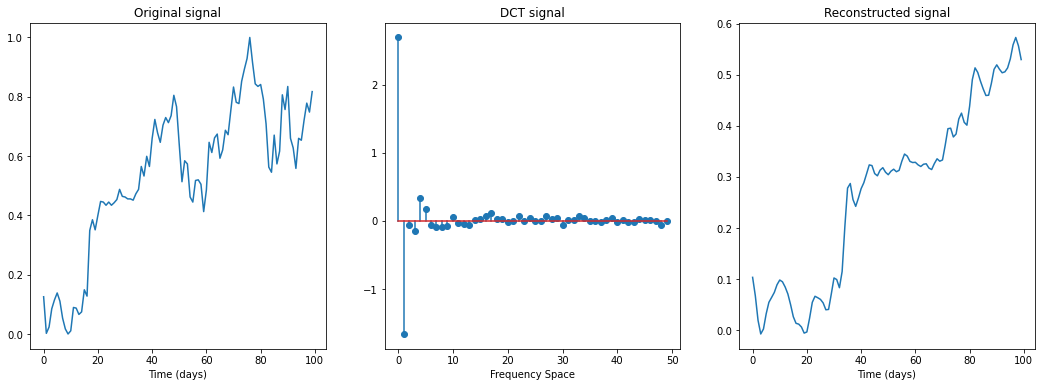

In [133]:
i = 10
y_cos = dct(X_scaled[i],norm='ortho',n=50)
fig, axes = plt.subplots(1,3,figsize=(18,6))

axes[0].plot(X_scaled[i])
axes[0].set_xlabel('Time (days)')
axes[0].set_title('Original signal')

axes[1].set_title('DCT signal')
axes[1].stem(y_cos)
axes[1].set_xlabel('Frequency Space')
axes[2].plot(idct(y_cos,norm='ortho',n=100))
axes[2].set_title('Reconstructed signal')
axes[2].set_xlabel('Time (days)')
plt.show()

DCT compression messes up the scale of the reconstructed signal and shifts patterns over time. We should be careful with this.

In [124]:
n_clusters = 20
km = KMeans(n_clusters)
km.fit(dct_X)
y_train_pred = km.predict(dct_X)


In [125]:
from collections import Counter
Counter(y_train_pred)

Counter({8: 115,
         14: 87,
         0: 28,
         10: 62,
         11: 49,
         4: 43,
         2: 42,
         3: 55,
         17: 74,
         7: 47,
         6: 57,
         9: 32,
         19: 48,
         18: 46,
         13: 45,
         15: 29,
         5: 39,
         12: 26,
         1: 32,
         16: 44})

<Figure size 864x504 with 0 Axes>

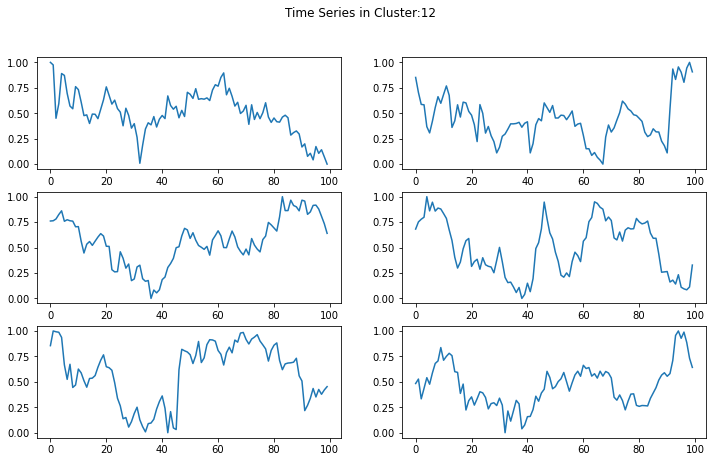

In [126]:
cluster_nb = 12
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(3, 2,figsize=(12,7))
fig.suptitle('Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_scaled[indices[0]])

axes[0,1].plot(X_scaled[indices[1]])

axes[1,0].plot(X_scaled[indices[2]])

axes[1,1].plot(X_scaled[indices[3]])

axes[2,0].plot(X_scaled[indices[4]])

axes[2,1].plot(X_scaled[indices[5]])

plt.show()

How do we know what good clusters look like? What properties could we measure to establish similarity between clusters.

In [129]:
dct_X = dct(X_scaled,norm='ortho',n=50)
dct_dtw_model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
dct_dtw_model.fit(dct_X)
y_train_pred = dct_dtw_model.predict(dct_X)
print(Counter(y_train_pred))

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Counter({10: 99, 0: 87, 1: 63, 3: 60, 17: 57, 9: 56, 12: 55, 13: 52, 11: 52, 5: 50, 19: 44, 2: 44, 16: 43, 7: 42, 15: 41, 18: 35, 14: 33, 8: 33, 6: 33, 4: 21})


<Figure size 864x504 with 0 Axes>

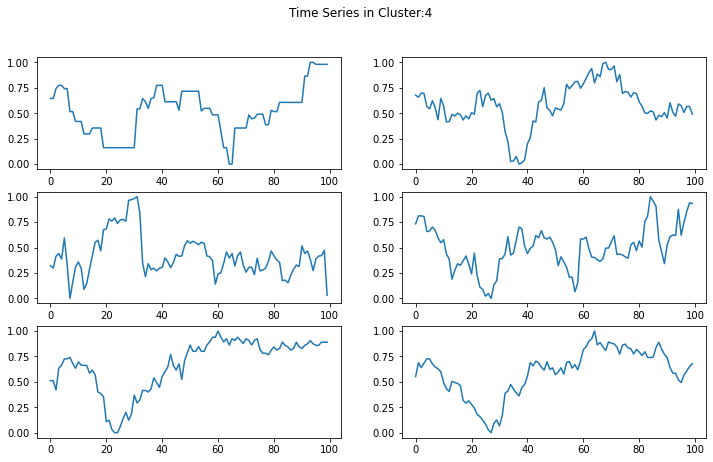

In [130]:
cluster_nb = 4
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(3, 2,figsize=(12,7))
fig.suptitle('Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_scaled[indices[0]])

axes[0,1].plot(X_scaled[indices[1]])

axes[1,0].plot(X_scaled[indices[2]])

axes[1,1].plot(X_scaled[indices[3]])

axes[2,0].plot(X_scaled[indices[4]])

axes[2,1].plot(X_scaled[indices[5]])

plt.show()

<Figure size 864x504 with 0 Axes>

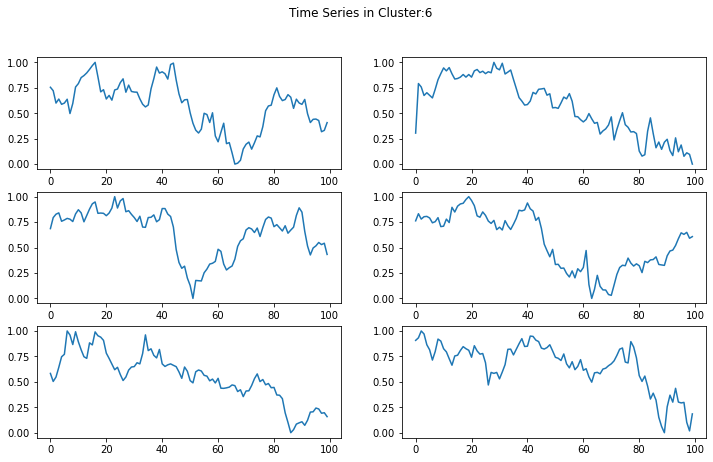

In [131]:
cluster_nb = 6
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(3, 2,figsize=(12,7))
fig.suptitle('Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_scaled[indices[0]])

axes[0,1].plot(X_scaled[indices[1]])

axes[1,0].plot(X_scaled[indices[2]])

axes[1,1].plot(X_scaled[indices[3]])

axes[2,0].plot(X_scaled[indices[4]])

axes[2,1].plot(X_scaled[indices[5]])

plt.show()

I'd like to explore this idea of maximum realignment between time series.

## Wavelets 



In [111]:
from pywt import dwt

In [124]:
X_dwt = dwt(X_scaled,pywt.Wavelet('db1'))
X_dwt_approx = X_dwt[0]
X_dwt_detail = X_dwt[1]
print(X_dwt_approx.shape)
print(X_dwt_detail.shape)


(800, 50)
(800, 50)


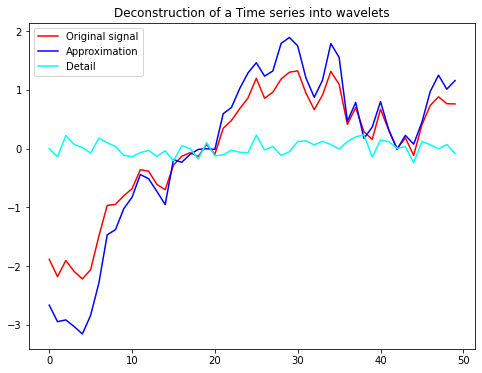

In [130]:
plt.figure(figsize=(8,6))
plt.plot(X_scaled[0][::2],color='r',label='Original signal')
plt.plot(X_dwt[0][0],color='b',label='Approximation')
plt.plot(X_dwt[1][0],color='cyan',label='Detail')
plt.title('Deconstruction of a Time series into wavelets')
plt.legend()
plt.show()

Looks complicated. I'll stop here for now.

## This is Naftali's clustering

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

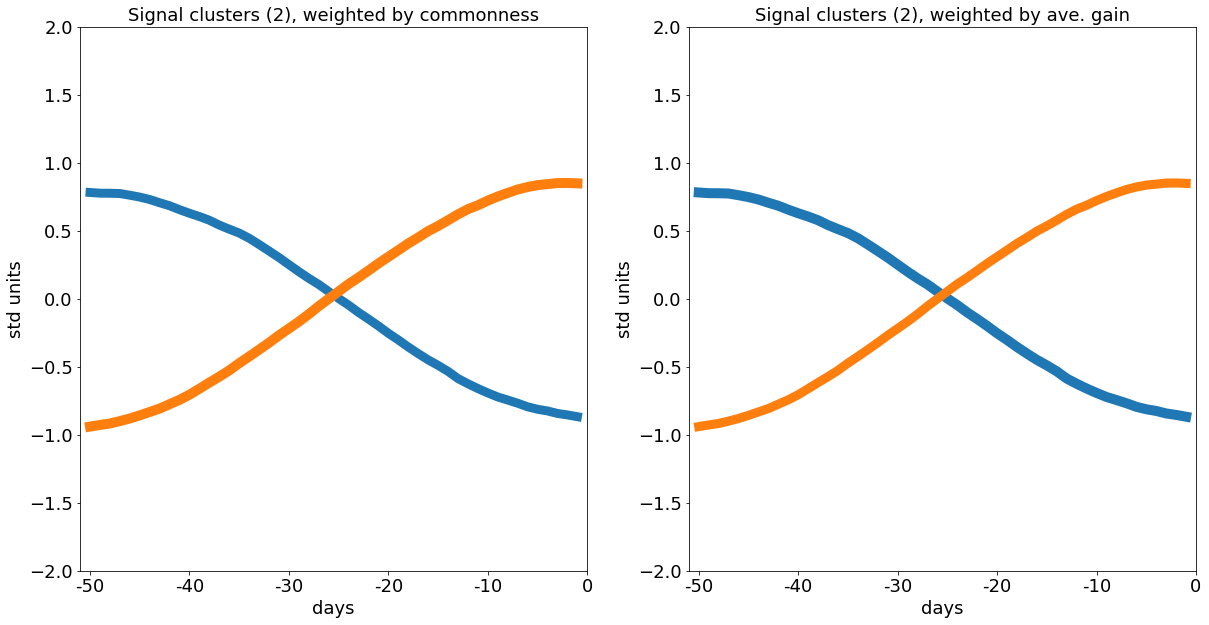

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

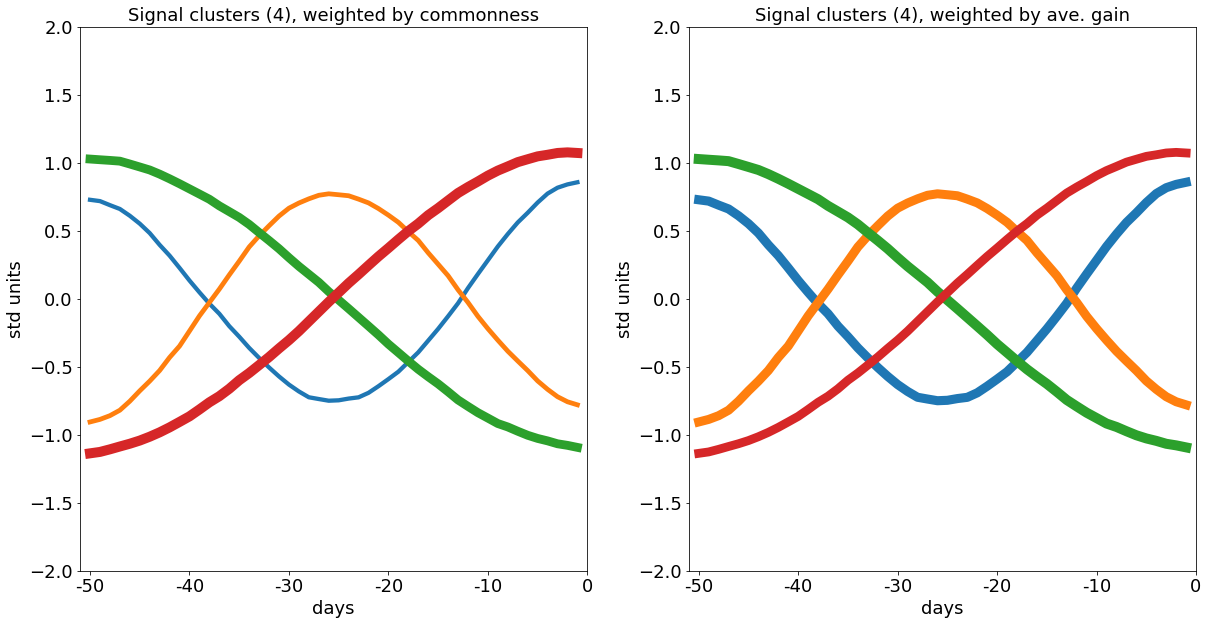

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

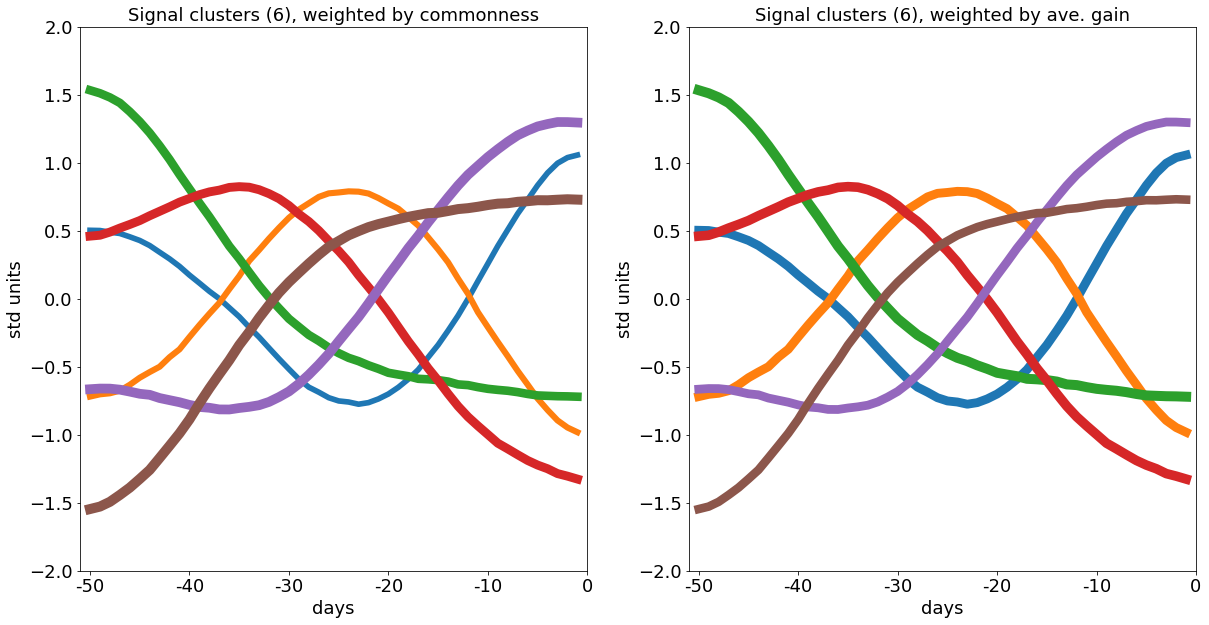

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

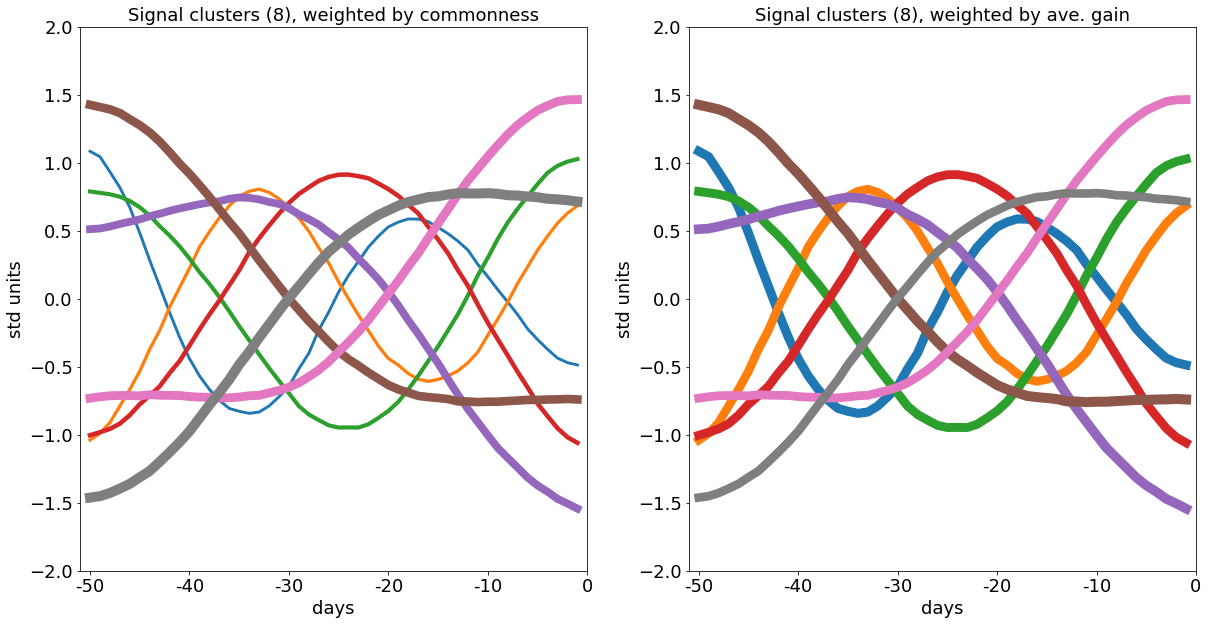

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans, SpectralClustering
cl=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
cl=['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636'][::-1]
#https://colorbrewer2.org/#type=sequential&scheme=PuRd&n=9

for n_clusters in [2,4,6,8]:
    clu = KMeans(n_clusters=n_clusters,random_state=0)

    clu.fit( X_data ); labels1 = clu.labels_

    fs=18;
    c=[]
    plt.figure(figsize=(20,10));
    plt.subplot(121)
    w1=[]
    for i in range(n_clusters):
        w1.append( len(X_data[labels1==i])/len(X_data) )
    fact=10/max(w1)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w1[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by commonness',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.subplot(122)
    w2=[]
    for i in range(n_clusters):
        w2.append( np.mean(y_data[labels1==i]) )
    fact=10/max(w2)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w2[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by ave. gain',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.savefig('cpp_'+str(n_clusters)+'_clustered_buy_signals.png',dpi=100,bbox_inches='tight',pad_inches=.05)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  


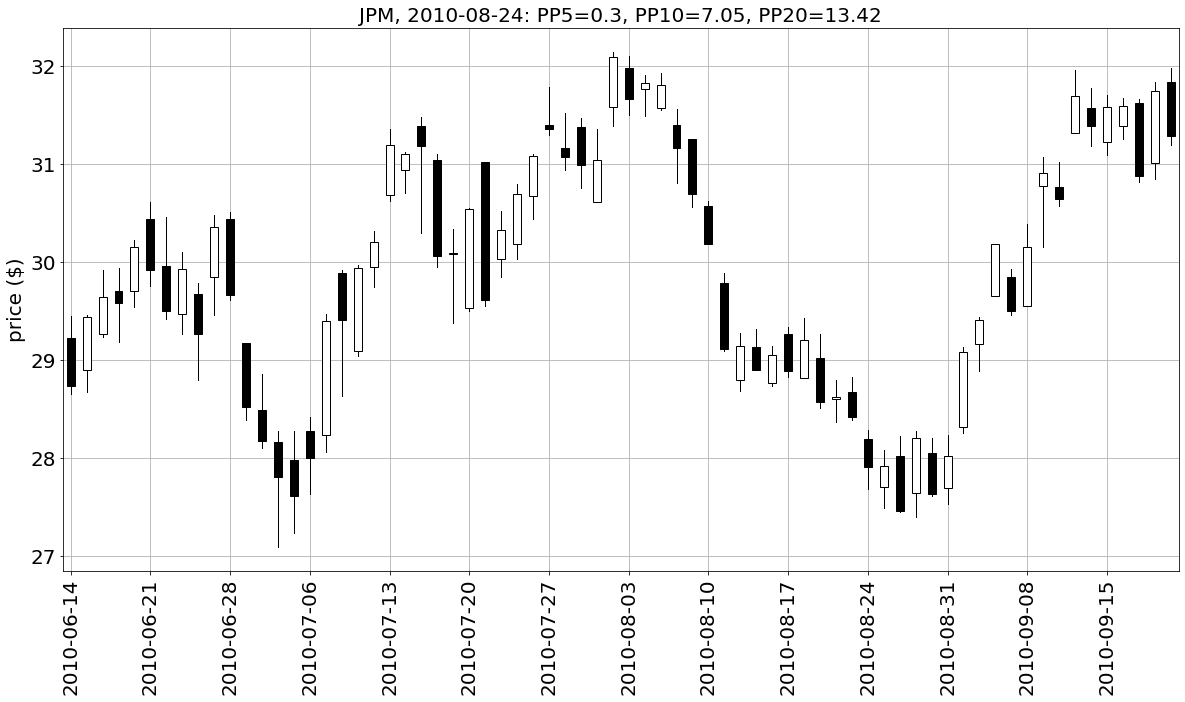

In [39]:
sym = 'JPM'
ind=list(df.loc[(df.loc[:,'Symbol']==sym) & (df.loc[:,'PP20']>10) & (df.loc[:,'Date']>'2010-01-01'),:].index.values)
ind=sample(ind,1)[0]
#ind=1178830
bwd_window=50; fwd_window = 20;
fs=20
a=df.loc[ind-bwd_window:ind+fwd_window-1,:][['Date','Open','Open','Open','High','Low','Close','Close','Close']].reset_index(drop=True)
a.Date=a.Date.astype(str)
data=np.array(a)[:,1:].T
#data=(data-np.min(np.min(data)))/(np.max(np.max(data))-np.min(np.min(data)))
xlabels=np.array(a)[:,0]
plt.figure(figsize=(20,10))
#plt.subplot(3,3,i+1)
bplot=plt.boxplot(data,showfliers=False,showcaps=False,whis='range',medianprops={'linewidth': 0},patch_artist=True,labels=xlabels)
colors=['white' if data[0,i]<data[7,i] else 'black' for i in range(data.shape[1]) ]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
#rr=round(df.loc[ind,'RR-5'],2),round(df.loc[ind,'RR-10'],2),round(df.loc[ind,'RR-20'],2)
pp=round(df.loc[ind,'PP5'],2),round(df.loc[ind,'PP10'],2),round(df.loc[ind,'PP20'],2)
d=str(df.loc[ind,'Date']).split(' ')[0]
#ratio=round(len(z_data[y>y_threshold,0][labels==i])/len(z_data[y>y_threshold,0]),2)
title=sym+', '+d+': PP5='+str(pp[0])+', PP10='+str(pp[1])+', PP20='+str(pp[2])
plt.title(title,fontsize=fs)
plt.ylabel('price ($)',fontsize=fs)
plt.xticks(range(1,len(xlabels)+1)[::5],xlabels[::5],fontsize=fs)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs)
plt.xticks(rotation=90)
plt.grid('on')
plt.savefig('pp_example.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


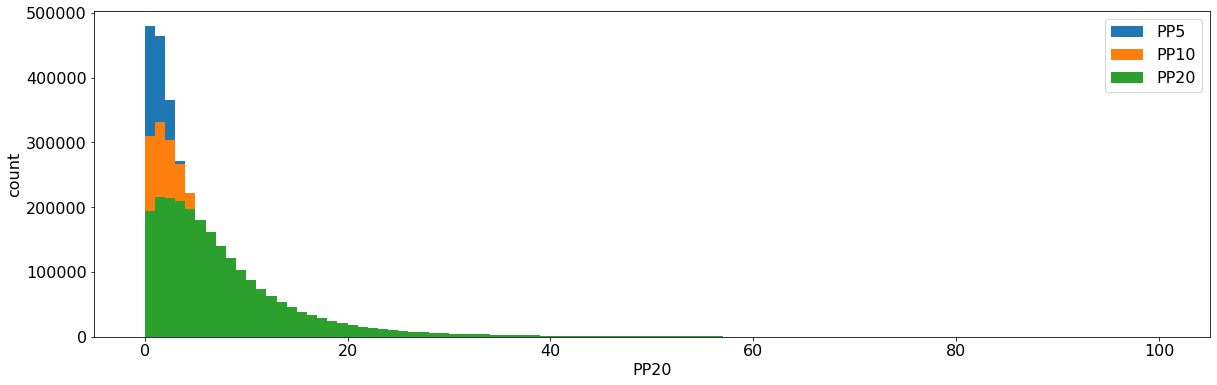

In [40]:
fs=16
plt.figure(figsize=(20,6))

x = df['PP5'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP10'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP20'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs);
plt.xlabel('PP20',fontsize=fs)
plt.ylabel('count',fontsize=fs)
plt.legend(['PP5','PP10','PP20'],fontsize=fs)
plt.savefig('pp_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()